# Time series forecasting

# Initial setup

## Import required packages

In [17]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")

## Import time series data: Airline passenger traffic

In [2]:
data = pd.read_csv('sales-data.csv', header = None)
data.columns = ['Year','Sales']
data['Year'] = pd.to_datetime(data['Year'], format='%Y-%m')
data = data.set_index('Year')
data.head(12)

,Sales
Year,
1980-01-01,154
1980-02-01,96
1980-03-01,73
1980-04-01,49
1980-05-01,36
1980-06-01,59
1980-07-01,95
1980-08-01,169
1980-09-01,219


# Time series analysis

## Plot time series data

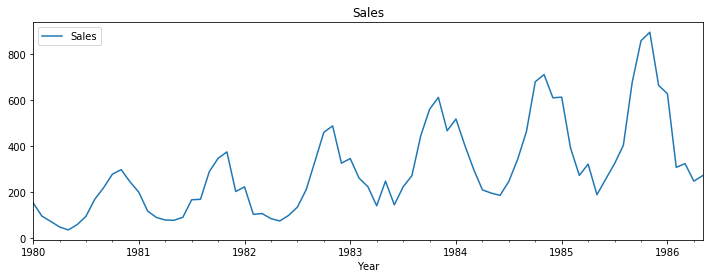

In [3]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales')
plt.show(block=False)

## Split time series data into training and test set

In [4]:
train_len = 60
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

### ADF Test

In [5]:
from statsmodels.tsa.stattools import adfuller
adf_test=adfuller(data['Sales'])
print('ADF statitistic: %f '%adf_test[0])
print("Critical value @ 0.05: %.2f"%adf_test[4]['5%'])
print('P-Value: %f' %adf_test[1])

ADF statitistic: 0.581906 
Critical value @ 0.05: -2.91
P-Value: 0.987161


### KPSS test

In [6]:
from statsmodels.tsa.stattools import kpss
kpss_test=kpss(data['Sales'])
print('kpss statitistic: %f '%kpss_test[0])
print("Critical value @ 0.05: %.2f"%kpss_test[3]['5%'])
print('P-Value: %f' %kpss_test[1])

kpss statitistic: 0.657628 
Critical value @ 0.05: 0.46
P-Value: 0.017397


### Boxcox Transformation

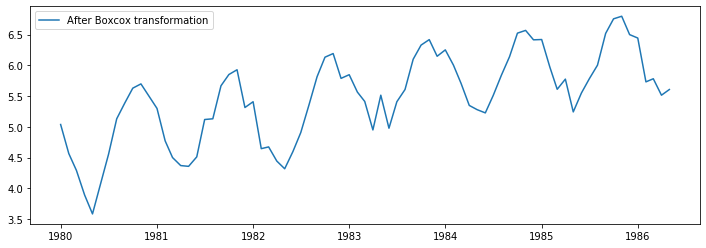

In [7]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Sales'],lmbda=0),index=data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox,label='After Boxcox transformation')
plt.legend(loc='best')
plt.show()


### Differencing

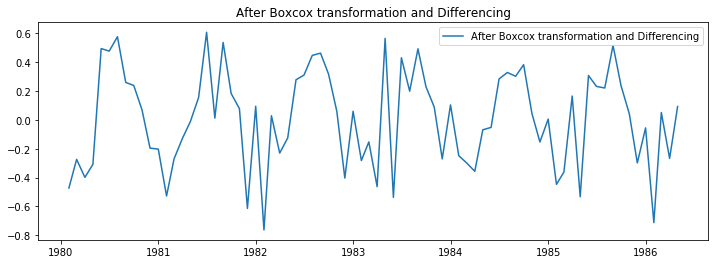

In [8]:
data_boxcox_diff=pd.Series(data_boxcox-data_boxcox.shift(),index=data.index)
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff,label='After Boxcox transformation and Differencing')
plt.legend(loc='best')
plt.title("After Boxcox transformation and Differencing")
plt.show()

### Autocorrelation function (ACF) plot

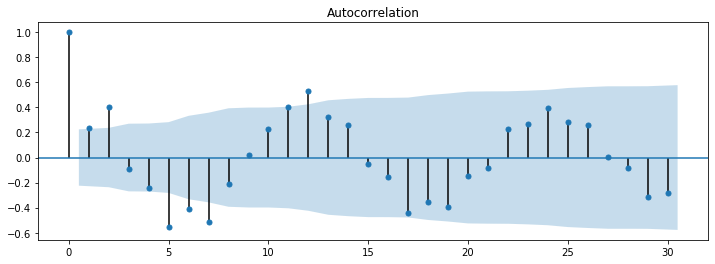

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff,ax=plt.gca(),lags=30)
plt.show()

### Partial Autocorrelation function (PACF) plot


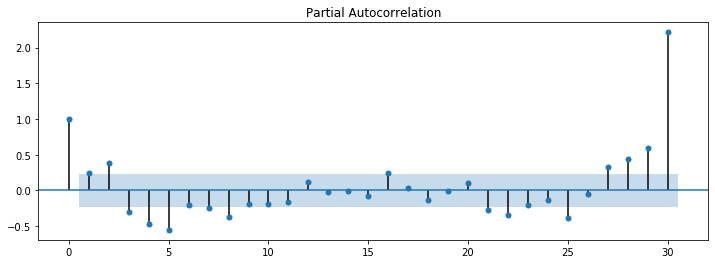

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff,ax=plt.gca(),lags=30)
plt.show()

### Split into train and test data sets

In [11]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

### Auto Regression Method (AR)

In [12]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff,order = (8,0,0))
model_fit=model.fit()
print(model_fit.summary())

C:\Users\susha\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   59
Model:                     ARMA(8, 0)   Log Likelihood                  14.465
Method:                       css-mle   S.D. of innovations              0.180
Date:                Mon, 27 Apr 2020   AIC                             -8.931
Time:                        21:04:03   BIC                             11.845
Sample:                    02-01-1980   HQIC                            -0.821
                         - 12-01-1984                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0211      0.008      2.686      0.010       0.006       0.037
ar.L1.y       -0.4310      0.123     -3.510      0.001      -0.672      -0.190
ar.L2.y        0.0271      0.119      0.227      0.8

### Recover original time series forecast

In [13]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

In [14]:
y_hat_ar['ar_forecast_boxcox_diff']

1980-02-01    0.021119
1980-03-01   -0.158846
1980-04-01   -0.217475
1980-05-01   -0.063661
1980-06-01   -0.038045
1980-07-01    0.194432
1980-08-01    0.466144
1980-09-01    0.451860
1980-10-01    0.418183
1980-11-01    0.069578
1980-12-01   -0.092442
1981-01-01   -0.407254
1981-02-01   -0.586086
1981-03-01   -0.330821
1981-04-01   -0.227841
1981-05-01    0.033073
1981-06-01    0.177188
1981-07-01    0.381551
1981-08-01    0.272030
1981-09-01    0.536879
1981-10-01    0.127759
1981-11-01    0.041670
1981-12-01   -0.243829
1982-01-01   -0.021757
1982-02-01   -0.581203
1982-03-01   -0.015665
1982-04-01   -0.265719
1982-05-01    0.156750
1982-06-01    0.259915
1982-07-01    0.497271
                ...   
1983-12-01   -0.137795
1984-01-01   -0.046871
1984-02-01   -0.289942
1984-03-01   -0.306329
1984-04-01   -0.216318
1984-05-01    0.007583
1984-06-01    0.069391
1984-07-01    0.320626
1984-08-01    0.230647
1984-09-01    0.264151
1984-10-01    0.302513
1984-11-01    0.170956
1984-12-01 

### Plot train,test and forecast

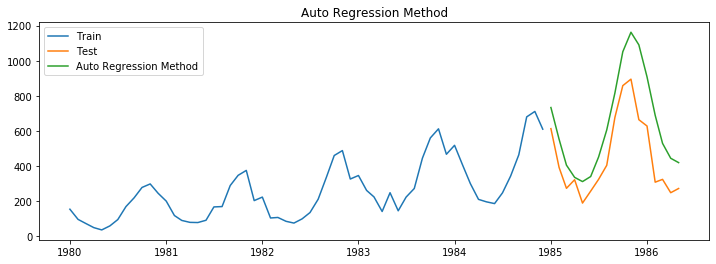

In [15]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto Regression Method')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Calculate RMSE and MAPE

In [20]:
rmse = np.sqrt(mean_squared_error(test['Sales'],y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Auto Regressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
tempResults

,Method,RMSE,MAPE
0,Auto Regressive (AR) method,213.17,47.15


### Moving Average Method (MA)

In [21]:
model = ARIMA(train_data_boxcox_diff,order = (0,0,3))
model_fit=model.fit()
print(model_fit.params)

const      0.015665
ma.L1.y    0.161512
ma.L2.y    0.534113
ma.L3.y    0.172928
dtype: float64


### Recover original time series forecast

In [22]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] =y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot train,test and forecast

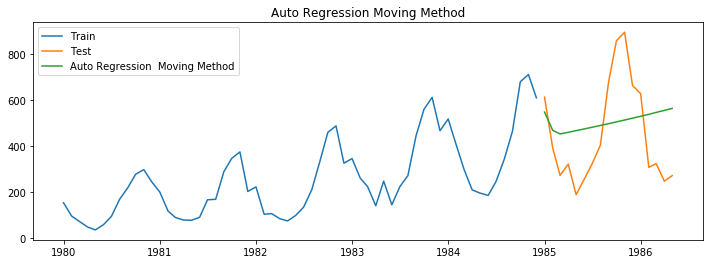

In [23]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Auto Regression  Moving Method')
plt.legend(loc='best')
plt.title('Auto Regression Moving Method')
plt.show()

### Calculate RMSE and MAPE

In [24]:
rmse = np.sqrt(mean_squared_error(test['Sales'],y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ma['ma_forecast'][test.index.min():])/test['Sales'])*100,2)

results = pd.DataFrame({'Method':['Auto Regressive Moving (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Auto Regressive Moving (MA) method,221.38,56.66
0,Auto Regressive (AR) method,213.17,47.15


### Auto Regressive Moving Average Method (ARMA)

In [25]:
model = ARIMA(train_data_boxcox_diff,order = (4,0,3))
model_fit=model.fit()
print(model_fit.params)

const      0.019244
ar.L1.y    0.257272
ar.L2.y    1.092253
ar.L3.y   -0.641709
ar.L4.y   -0.480929
ma.L1.y   -0.807334
ma.L2.y   -0.764253
ma.L3.y    0.977573
dtype: float64


### Recover original time series forecast

In [26]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum() 
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train,test and forecast

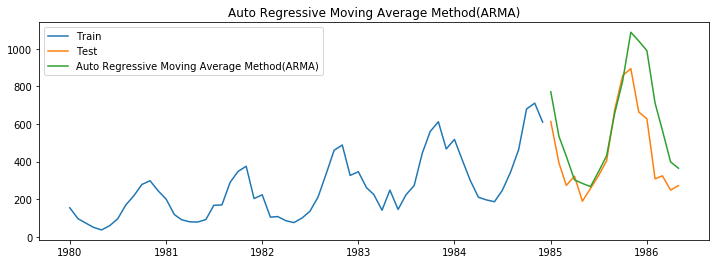

In [27]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='Auto Regressive Moving Average Method(ARMA)')
plt.legend(loc='best')
plt.title('Auto Regressive Moving Average Method(ARMA)')
plt.show()

### Calculate RMSE and MAPE

In [28]:
rmse = np.sqrt(mean_squared_error(test['Sales'],y_hat_arma['arma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arma['arma_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Auto Regressive Moving Average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Auto Regressive Moving (MA) method,221.38,56.66
0,Auto Regressive (AR) method,213.17,47.15
0,Auto Regressive Moving Average (ARMA) method,194.81,37.31


### Auto Regressive Integrated  Moving Average Method (ARIMA)

In [29]:
model = ARIMA(train_data_boxcox,order = (4,1,3))
model_fit=model.fit()
print(model_fit.params)

const        0.019244
ar.L1.D.y    0.257272
ar.L2.D.y    1.092253
ar.L3.D.y   -0.641709
ar.L4.D.y   -0.480929
ma.L1.D.y   -0.807334
ma.L2.D.y   -0.764253
ma.L3.D.y    0.977573
dtype: float64


### Recover original time series forecast

In [30]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum() 
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train,test and forecast

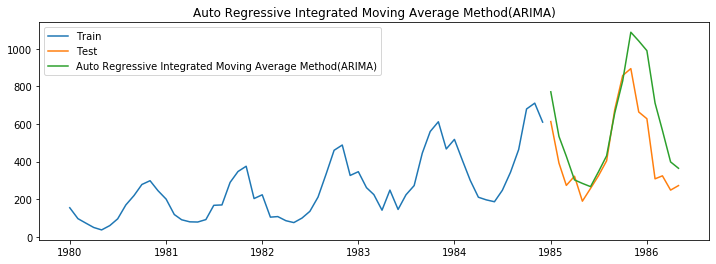

In [32]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='Auto Regressive Integrated Moving Average Method(ARIMA)')
plt.legend(loc='best')
plt.title('Auto Regressive Integrated Moving Average Method(ARIMA)')
plt.show()

### Calculate RMSE and MAPE

In [33]:
rmse = np.sqrt(mean_squared_error(test['Sales'],y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Auto Regressive Integrated Moving Average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Auto Regressive Moving (MA) method,221.38,56.66
0,Auto Regressive (AR) method,213.17,47.15
0,Auto Regressive Moving Average (ARMA) method,194.81,37.31
0,Auto Regressive Integrated Moving Average (ARI...,194.81,37.31


### Seasonal Auto Regressive Integrated Moving Average(SARIMA)

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_data_boxcox,order = (7,2,9),seasonal_order = (3,1,1,12))
model_fit=model.fit()
print(model_fit.params)

ar.L1      -1.224312
ar.L2      -0.707223
ar.L3      -0.091403
ar.L4      -0.119928
ar.L5      -0.556756
ar.L6      -0.713368
ar.L7      -0.379045
ma.L1      -0.254668
ma.L2      -0.507623
ma.L3      -0.315099
ma.L4       0.338613
ma.L5       0.184707
ma.L6      -0.264021
ma.L7      -0.630138
ma.L8      -0.220294
ma.L9       0.686990
ar.S.L12   -0.415395
ar.S.L24   -0.258958
ar.S.L36   -0.659631
ma.S.L12   -0.254944
sigma2      0.017496
dtype: float64


### Recover original time series forecast

In [36]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train,test and forecast

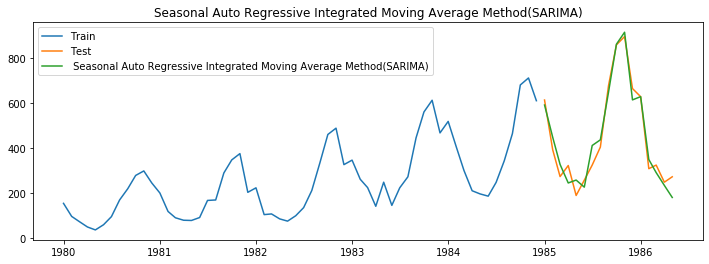

In [37]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label=' Seasonal Auto Regressive Integrated Moving Average Method(SARIMA)')
plt.legend(loc='best')
plt.title('Seasonal Auto Regressive Integrated Moving Average Method(SARIMA)')
plt.show()

### Calculate RMSE and MAPE

In [38]:
rmse = np.sqrt(mean_squared_error(test['Sales'],y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal Auto Regressive Integrated Moving Average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Auto Regressive Moving (MA) method,221.38,56.66
0,Auto Regressive (AR) method,213.17,47.15
0,Auto Regressive Moving Average (ARMA) method,194.81,37.31
0,Auto Regressive Integrated Moving Average (ARI...,194.81,37.31
0,Seasonal Auto Regressive Integrated Moving Ave...,49.66,13.07
